# Generating plots for different algorithms

In [7]:
from stable_baselines3 import PPO, DQN, A2C, SAC
import numpy as np
import pandas as pd
from meal_planning_environment import MaxNutritionEnv, HeuristicEnv, GPTOnlyEnv, RLHFEnv
from meal_planning_environment import run_with_learning_algorithm
from dietkit import load_ingredient, load_menu, load_diet

import os 

log_dir = "./tmp/gym/"
os.makedirs(log_dir, exist_ok=True)


## Initialize dietkit

In [8]:
all_ingredients = load_ingredient(sample_language = 'eng')
meal_dict = load_menu(ingredients = all_ingredients, sample_language = 'eng')
example_mealplans = load_diet(menus = meal_dict, num_loads = 100, sample_language = 'eng', sample_name = 'ML')

possible_meals = np.array(list(meal_dict.keys()))
meal_categories = np.array([meal.category if isinstance(meal.category, str) else meal.category[0] for meal in meal_dict.values()])
nutrition_data = pd.DataFrame([meal.nutrition for meal in meal_dict.values()], index=possible_meals)

display(possible_meals)
display(nutrition_data)

Exception ignored in: <function Menu.__del__ at 0x15c7288b0>
Traceback (most recent call last):
  File "/Users/lucasrosenblatt/opt/miniconda3/envs/new_rl/lib/python3.10/site-packages/dietkit/elements.py", line 89, in __del__
    del Menu.__catalog[self.name]
KeyError: 'Mushroom perilla seed soup'
Exception ignored in: <function Menu.__del__ at 0x15c7288b0>
Traceback (most recent call last):
  File "/Users/lucasrosenblatt/opt/miniconda3/envs/new_rl/lib/python3.10/site-packages/dietkit/elements.py", line 89, in __del__
    del Menu.__catalog[self.name]
KeyError: 'Zucchini soup'
Exception ignored in: <function Menu.__del__ at 0x15c7288b0>
Traceback (most recent call last):
  File "/Users/lucasrosenblatt/opt/miniconda3/envs/new_rl/lib/python3.10/site-packages/dietkit/elements.py", line 89, in __del__
    del Menu.__catalog[self.name]
KeyError: 'Potato zucchini soup'
Exception ignored in: <function Menu.__del__ at 0x15c7288b0>
Traceback (most recent call last):
  File "/Users/lucasrosenblat

array(['S watermelon punch (without milks)', 'Dried persimmon',
       'S kyogo grape (100g)', ..., 'Green onion kimchi',
       'Pickled paprika', 'empty'], dtype='<U72')

,Energy,Protein,Fat,Carbohydrate,Total Dietary,Calcium,Iron,Sodium,Vitamin A,Vitamin B1 (Thiamine),Vitamin B2 (Rivoflavin),Vitamin C,Linoleic Acid,Alpha-Linolenic Acid
S watermelon punch (without milks),55.00,0.7900,0.05000,13.8180,0.200,7.200,0.18600,0.600,71.083333,0.024000,0.03000,0.0000,14.2500,2.9300
Dried persimmon,76.50,0.5820,0.04800,20.5830,3.360,6.300,0.19200,0.900,13.725000,0.003000,0.06720,1.5330,0.0000,8.6010
S kyogo grape (100g),61.00,0.4300,0.04000,16.3800,0.400,4.000,0.17000,1.000,2.166667,0.026000,0.04700,0.1300,11.8900,6.0900
S dried persimmon,85.60,0.7720,0.03200,22.9800,3.400,5.600,0.24800,0.400,9.533333,0.003600,0.09720,1.0680,0.0000,5.0440
S fruit punch,101.05,3.6700,3.36450,14.8900,0.790,117.650,0.19850,36.000,91.166667,0.040350,0.19110,1.8925,86.6605,10.6925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Ponytail radish kimchi,10.25,0.5050,0.05000,1.9725,0.775,10.500,0.16750,173.000,5.541667,0.003250,0.01900,0.4125,19.7050,9.4775
Kohlrabi watery kimchi,5.50,0.2900,0.01250,1.2900,0.600,10.500,0.06750,1.750,0.250000,0.203750,0.00875,0.0000,1.9650,5.1100
Green onion kimchi,12.25,0.6250,0.14500,2.1275,1.150,15.000,0.18250,163.750,26.854167,0.012750,0.02850,0.5550,79.8050,17.1425
Pickled paprika,7.94,0.2017,0.03005,1.9859,0.348,1.675,0.08145,67.204,4.850000,0.003675,0.02709,24.2820,12.4483,6.5448


## Initialize MealPlanningEnv
Choose from the following environments:
1. MaxNutritionEnv
2. HeuristicEnv
3. GPTOnlyEnv
4. RLHFEnv

In [9]:
num_meals = 21
env = MaxNutritionEnv(possible_meals=possible_meals, meal_categories=meal_categories, nutrition_data=nutrition_data, num_meals=num_meals)

### Test A2C

Using cpu device
Wrapping the env in a DummyVecEnv.
Initial Results
Step: 21
Chosen Meal: Seasoned salad with wild chive
Chosen Meal Category: Salad
Meal History: ['Unpressed tofu octopus soup' 'Chive egg soup'
 'Macaroni and vegetable salad (tomato sauce)'
 'S cheese mini-gimbap (rice roll)' 'S deep-fried shrimp'
 'Ground beef kimchi fried rice' 'S potato salad' 'Shrimp tofu soup'
 'Seasoned salad with hijiki' 'Sujebi with potato'
 'Seasoned salad with lettuce and apple' 'Mild soy puree stew'
 'Cabbage corn salad' 'Bibimbap with winter herbs' 'Braised potato'
 'Pan-fried cuttlefish dumpling (homestyle)'
 'Stir-fried pork and vegetables with rice'
 'Roasted smoked duck with vagetable' 'Steamed chestnut rice'
 'Braised chicken with perilla leaves' 'Seasoned salad with wild chive']
Category History: ['Soup' 'Soup' 'Salad' 'Combo meal (snack)' 'Combo meal (snack)'
 'Combo meal rice' 'Salad (snack)' 'Soup' 'Salad' 'Noodles' 'Salad' 'Soup'
 'Salad' 'Combo meal rice' 'Braised' 'Pancake' 'Com

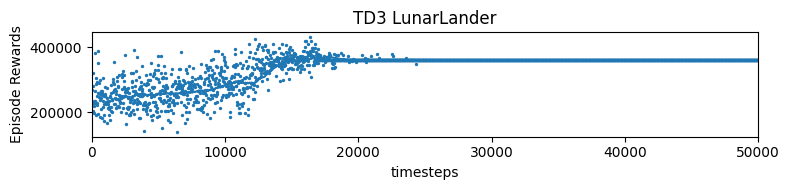

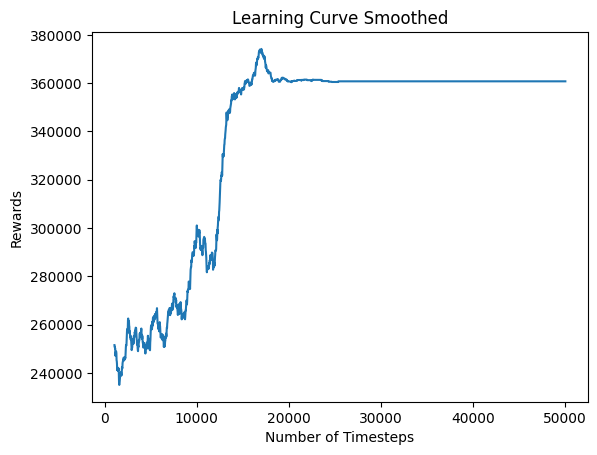

(<stable_baselines3.a2c.a2c.A2C at 0x15ec36e30>,
 <Monitor<MaxNutritionEnv instance>>)

In [10]:
run_with_learning_algorithm(A2C, env, 50000, log_dir, num_meals=21, seed=0)

### Test DQN

Using cpu device
Wrapping the env in a DummyVecEnv.
Initial Results
Step: 21
Chosen Meal: Grilled mackerel in curry
Chosen Meal Category: Grilled
Meal History: ['Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi' 'Grilled mackerel in curry'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi'
 'Stir-fried boneless pork and kimchi' 'Taro soup'
 'Grilled mackerel in curry' 'Grilled mackerel in curry']
Category History: ['Stir-fried' 'Stir-fried' 'Stir-fried' 'Stir-fried' 'Stir-fr

/Users/lucasrosenblatt/opt/miniconda3/envs/new_rl/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:564: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 3.26GB > 2.69GB
  warnings.warn(


----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21       |
|    ep_rew_mean      | 2.61e+05 |
|    exploration_rate | 0.936    |
| time/               |          |
|    episodes         | 32       |
|    fps              | 3328     |
|    time_elapsed     | 0        |
|    total_timesteps  | 672      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21       |
|    ep_rew_mean      | 2.58e+05 |
|    exploration_rate | 0.928    |
| time/               |          |
|    episodes         | 36       |
|    fps              | 3442     |
|    time_elapsed     | 0        |
|    total_timesteps  | 756      |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 21       |
|    ep_rew_mean      | 2.54e+05 |
|    exploration_rate | 0.92     |
| time/               |          |
|    episodes       

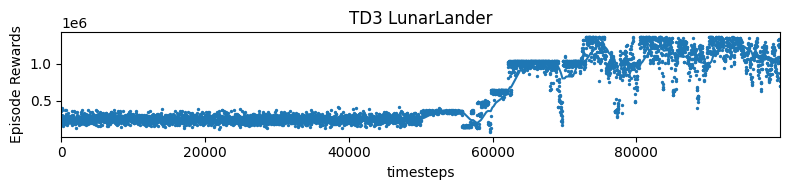

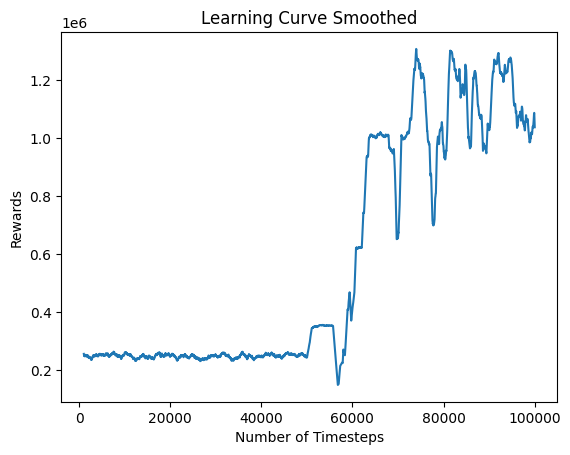

(<stable_baselines3.dqn.dqn.DQN at 0x15ed022c0>,
 <Monitor<MaxNutritionEnv instance>>)

In [11]:
run_with_learning_algorithm(DQN, env, 100000, log_dir, num_meals=21, seed=0)

### etc...